# 다양한 OCR모델 비교하기

우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.

지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있었습니다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을것도 같습니다. 그런데 과연 어떤 것을 사용하는 것이 좋을까요?

OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.

## Step1. 검증용 데이터셋 준비

OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

step_3에서 여러사진을 통해 비교를 진행해 보도록하겠습니다.

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

위 3가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다.

일단 google에서 get한 자동차 번호판을 갖고서 세가지 방법으로 OCR을 진행 해보도록 하겠습니다.

In [1]:
import os
import glob

work_dir = os.getenv('HOME')+'/aiffel/ocr_python/imgs'
img_file_path = glob.glob(work_dir+'/license_plate.jpg')

In [2]:
print(img_file_path)

['/home/aiffel/aiffel/ocr_python/imgs/license_plate.jpg']


In [3]:
import matplotlib.pyplot as plt

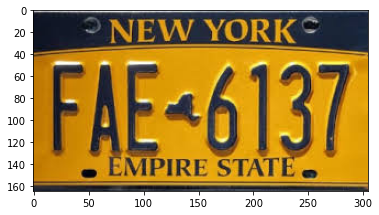

In [4]:
test_picture = plt.imread(img_file_path[0])

plt.figure(figsize=(6,6))
plt.imshow(test_picture)

### Google OCR API사용하기

In [5]:
def Google_OCR(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [6]:
Google_OCR(img_file_path[0])

Texts:

"NEW YORK
FAE-6137
EMPIRE STATE.
"

"NEW"

"YORK"

"FAE-6137"

"EMPIRE"

"STATE."
bounds: (168,132),(258,133),(258,153),(168,152)


### keras-ocr 사용하기

In [7]:
import os
import glob

work_dir = os.getenv('HOME')+'/aiffel/ocr_python/imgs'
img_file_paths = glob.glob(work_dir+'/license_plate.jpg')

In [8]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel/.keras-ocr/crnn_kurapan.h5


In [9]:
images = [keras_ocr.tools.read(file_path) for file_path in img_file_paths]
prediction_groups = [pipeline.recognize([file_path]) for file_path in img_file_paths]

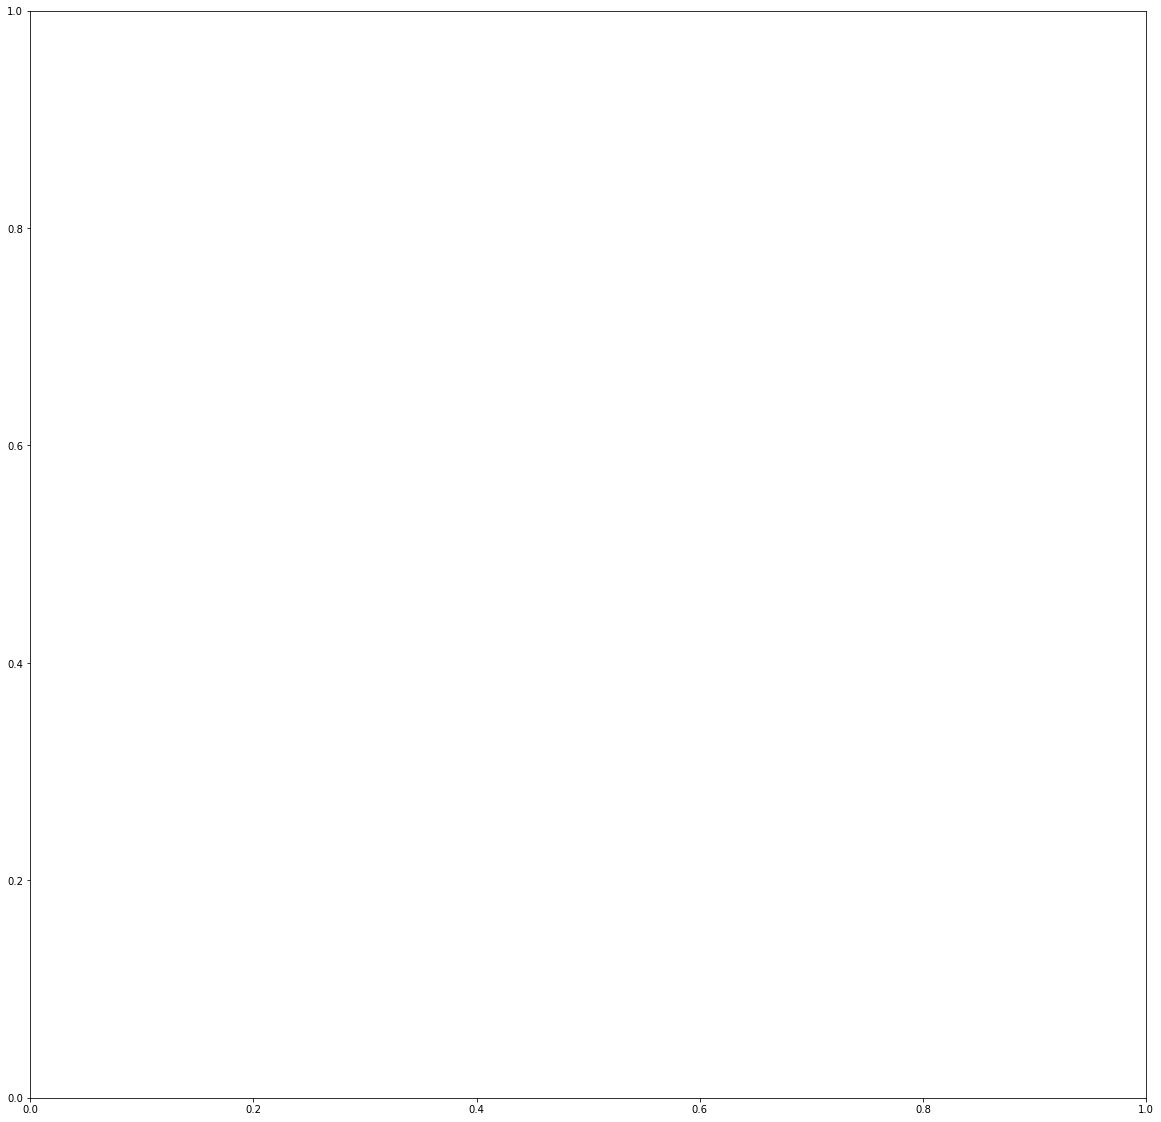

In [10]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20), squeeze=False)

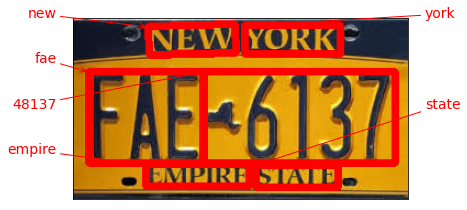

In [11]:
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0],ax = None)

### 테서렉트 사용하기

In [12]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

In [13]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path,f"{str(index)}.png")
            #print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [14]:
try:
    cropped_image_path_list = crop_word_regions(img_file_path[0], work_dir)
except:
    print('teceract cannot do OCR')

teceract cannot do OCR


In [15]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("---------------Done-----------------")

In [16]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
try:
    recognize_images(cropped_image_path_list)
except:
    print('teceract cannot do OCR')

teceract cannot do OCR


어찌된 영문인지 인식을 하지 못하는 것 같습니다..

### 다양한 사진 OCR 적용해보기

이제 여러 사진들을 한번에 인식하여 비교해보도록 하겠습니다.

준비된사진은 영화 포스터들과 외국의 표지판들입니다.

In [17]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/imgs'
img_file_paths = glob.glob(work_dir+'/*.jpg')

In [18]:
print(img_file_paths)

['/home/aiffel/aiffel/ocr_python/imgs/INCEPTION.jpg', '/home/aiffel/aiffel/ocr_python/imgs/TENET.jpg', '/home/aiffel/aiffel/ocr_python/imgs/TENET_2.jpg', '/home/aiffel/aiffel/ocr_python/imgs/INCEPTION_2.jpg', '/home/aiffel/aiffel/ocr_python/imgs/license_plate.jpg', '/home/aiffel/aiffel/ocr_python/imgs/Notice_in_sign.jpg']


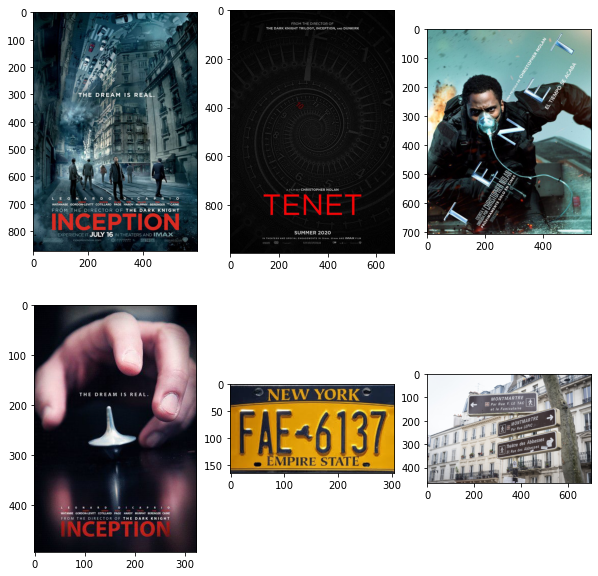

In [19]:
plt.figure(figsize=(10,10))
for i in range(len(img_file_paths)):
    pictures = plt.imread(img_file_paths[i])
    plt.subplot(2,3,i+1)
    plt.imshow(pictures)

In [20]:
for i in range(len(img_file_paths)):
    Google_OCR(img_file_paths[i])
    print('--------------------Done------------------')

Texts:

"THE DREAM IS REAL.
L
E ON ARD o
DICA PRIO
MARION
ELLEN
IGMAEL
CAINE
OSEPH
AND
WATANABE GORDON-LEVITT COTILLARD PAGE HARDY MURPHY BERENGER
FROM THE DIRECTOR OF THE DARK KNIGHT
INCEPTION
EXPERIENCE IT JULY 16 IN THEATERS AND IMAX
inceptionmovie.com
SLEGENDARY
MARNER IROS MCTURES
"

"THE"

"DREAM"

"IS"

"REAL."

"L"

"E"

"ON"

"ARD"

"o"

"DICA"

"PRIO"

"MARION"

"ELLEN"

"IGMAEL"

"CAINE"

"OSEPH"

"AND"

"WATANABE"

"GORDON-LEVITT"

"COTILLARD"

"PAGE"

"HARDY"

"MURPHY"

"BERENGER"

"FROM"

"THE"

"DIRECTOR"

"OF"

"THE"

"DARK"

"KNIGHT"

"INCEPTION"

"EXPERIENCE"

"IT"

"JULY"

"16"

"IN"

"THEATERS"

"AND"

"IMAX"

"inceptionmovie.com"

"SLEGENDARY"

"MARNER"

"IROS"

"MCTURES"
bounds: (517,833),(541,833),(541,836),(517,836)
--------------------Done------------------
Texts:

"FROM THE DIRECTOR OF
THE DARK KNIGHT TRILOGY, INCEPTION, AND DUNKIRK
CO
8H3
A FILM BY CHRISTOPHER NOLAN
TENET
SUMMER 2020
IN THEATERSS AND SPECIAL ENGAGEMENTS IN 70 mm, 35 mm AND IMAX FILM
SYACET
MA

In [21]:
def KERAS_OCR(img_file_paths):
    
    import matplotlib.pyplot as plt
    import keras_ocr

    pipeline = keras_ocr.pipeline.Pipeline()
    
    images = [keras_ocr.tools.read(file_path) for file_path in img_file_paths]
    prediction_groups = [pipeline.recognize([file_path]) for file_path in img_file_paths]
    
    # Plot the predictions
    fig, axs = plt.subplots(nrows=len(images), figsize=(30, 30))
    for idx, ax in enumerate(axs):
        keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0],ax = ax)

Looking for /home/aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /home/aiffel/.keras-ocr/crnn_kurapan.h5


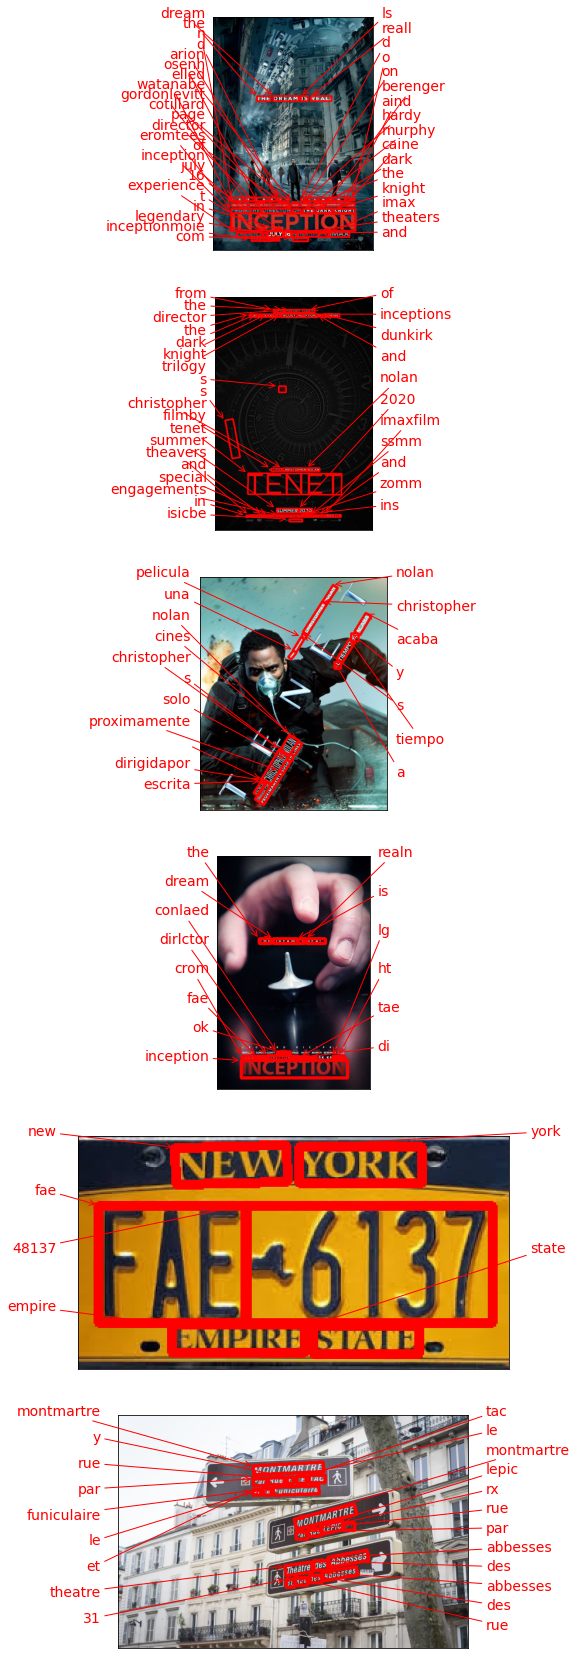

In [22]:
KERAS_OCR(img_file_paths)

In [23]:
def teseract_OCR(img_file_paths, work_dir):
    for i in range(len(img_file_paths)):
        try:
            cropped_image_path_list = crop_word_regions(img_file_paths[i], work_dir)
            recognize_images(cropped_image_path_list)
        except:
            print('\n','teseract cannot do OCR')
            print('\n---------------Done-----------------')
        
    

In [24]:
teseract_OCR(img_file_paths, work_dir)

6

ely =

ma,

eA «Yikes 2

TaN TTT

rere

PDON-LEVITT

COTILLARD

ey

oe

BERENGER “° CAINE

mse) i

1a.

Baa.

= On ke,

Pen ene fee er: ee ee ot

NIG

see


aod). , :

Sadie Le

=a

ie JULY

i)

pean

A

hea

laleccielae


a

---------------Done-----------------
be CM

iti

Bia eake)=.

3)=

THE DAR

K KN

iGHT T

RILOGY, INC

ePTION

ie ele

NKIRK

S38 eae.

Sib EO) =) ie Ola



a

SUMMER

2020

iN TREAT

ee See eS

Rea: i ae eae

GEMENTS IN 7JOmm. 35mm AND I

'WiFA Mm FILM

---------------Done-----------------

 teseract cannot do OCR

---------------Done-----------------
ei

---------------Done-----------------

 teseract cannot do OCR

---------------Done-----------------
MONTMARTRE

j

=


RZ

shih

4

aS

ere

et le Funiculaire


---------------Done-----------------


## Step3&4. 테스트 결과 정리 및 분석

### Google_OCR_API
- OCR분석 측면에서 3가지 중 최고의 성능을 보이고 있다. 하지만 이를 시각적으로 표현하지는 못하는 듯하다.

### Keras_ocr
- OCR분석 측면에서 2순위의 성능을 보이고 있다. 간혹 글자인식에서 부족한 면을 보이고 있지만 이 정도면 양호한 수준이므로 사용하기에 충분함을 알수있다. 또 글자마다의 바운더리를 표시해주기 때문에 시각적으로 표현하기 용이하다.

### Teseract_ocr
- OCR 분석에서나 시각적 표현 측면에서나 아쉬운 성능을 보이고 있다.

OCR분석이 중요하다면 Google_OCR_API를 시각적인 표현이 중요하다면 Keras_ocr을 사용하면 될 것같다. (Google_OCR_API에서 바운더리를 표시해준걸로 봐서 좀 더 찾아보면 Keras_ocr같은 시각적 표현이 가능할것으로 보인다. 사실 ocr과정에서 글자 이미지를 찾은후에 문자로 인식하기 때문에 가능할 것이다..!(개인적인 생각이다))